# 03wk-2: 깊은신경망 – 로지스틱한계극복

최규빈  
2024-03-18

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/03wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

In [ ]:
# {{<video https://youtu.be/playlist?list=PLQqh36zP38-wO_Mc_74QoweAxCWw5A86_&si=iWAgttM-CIgsi1x3 >}}

# 2. Imports

In [2]:
import torch
import matplotlib.pyplot as plt 
import pandas as pd

# 3. 꺽인그래프를 만드는 방법

`-` 로지스틱의 한계를 극복하기 위해서는 시그모이드를 취하기 전에 꺽인
그래프 모양을 만드는 기술이 있어야겠음.

`-` 아래와 같은 벡터 ${\boldsymbol x}$를 가정하자.

In [3]:
x = torch.linspace(-1,1,1001).reshape(-1,1)
x

`-` 목표: 아래와 같은 벡터 ${\boldsymbol y}$를 만들어보자.

$${\boldsymbol y} = [y_1,y_2,\dots,y_{n}], \quad y_i = \begin{cases} 9x_i +4.5& x_i <0 \\ -4.5x_i + 4.5& x_i >0 \end{cases}$$

## A. 방법1

In [4]:
y = x*0 
y[x<0] = (9*x+4.5)[x<0]
y[x>0] = (-4.5*x+4.5)[x>0]

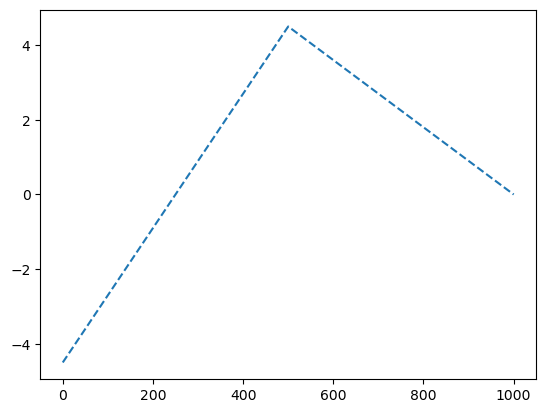

In [5]:
plt.plot(y,'--')

## B. 방법2 – 렐루이용

In [6]:
relu = torch.nn.ReLU()

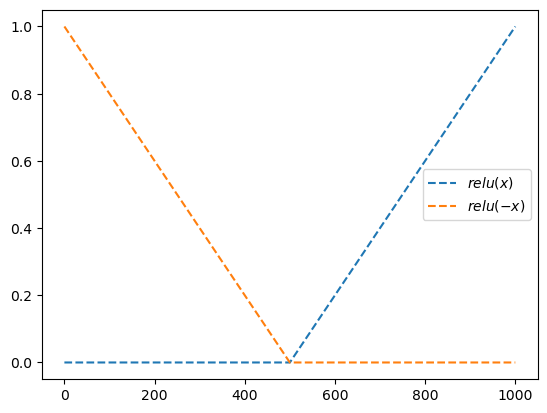

In [7]:
plt.plot(relu(x),'--',label=r'$relu(x)$')
plt.plot(relu(-x),'--',label=r'$relu(-x)$')
plt.legend()

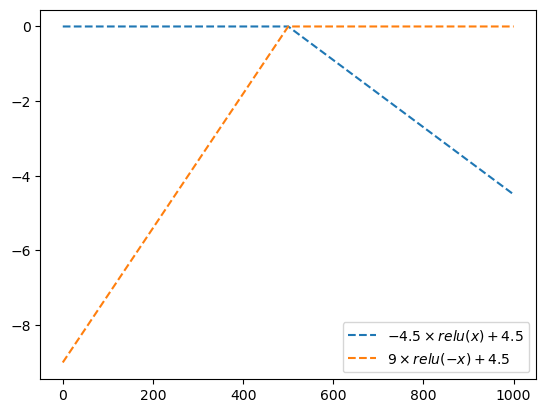

In [8]:
plt.plot(-4.5*relu(x),'--',label=r'$-4.5\times relu(x) + 4.5$')
plt.plot(-9*relu(-x),'--',label=r'$9\times relu(-x) + 4.5$')
plt.legend()

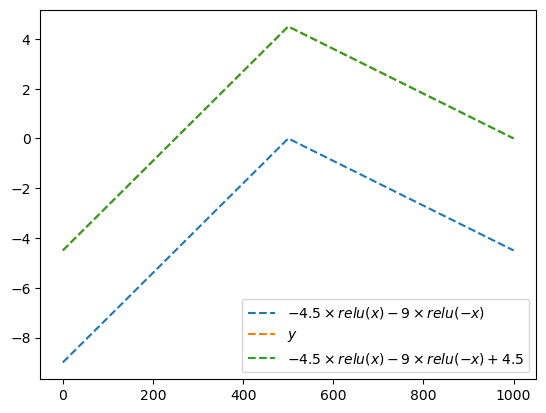

In [9]:
plt.plot(-4.5*relu(x)-9*relu(-x),'--',label=r'$-4.5\times relu(x) -9 \times relu(-x)$')
plt.plot(y,'--',label=r'$y$')
plt.plot(-4.5*relu(x)-9*relu(-x)+4.5,'--',label=r'$-4.5\times relu(x) -9 \times relu(-x)+4.5$')
plt.legend()

`-` 우리의 목표: 저 초록선에서 시그모이드를 태우면된다. 즉 아래의 느낌임

In [10]:
sig = torch.nn.Sigmoid()

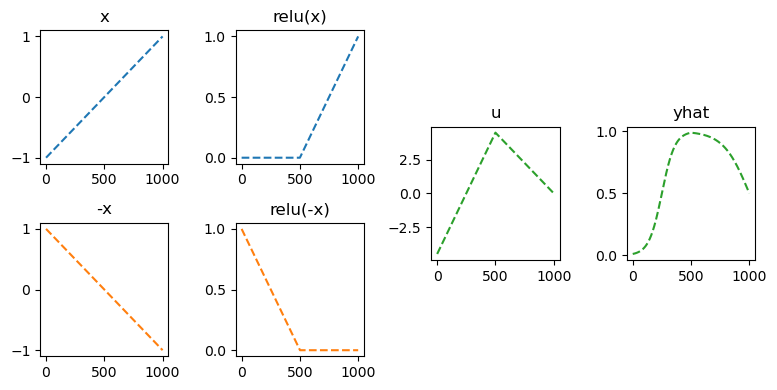

In [11]:
fig = plt.figure(figsize=(8, 4))
spec = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(spec[:2,0]); ax1.set_title('x')
ax2 = fig.add_subplot(spec[2:,0]); ax2.set_title('-x')
ax3 = fig.add_subplot(spec[:2,1]); ax3.set_title('relu(x)')
ax4 = fig.add_subplot(spec[2:,1]); ax4.set_title('relu(-x)')
ax5 = fig.add_subplot(spec[1:3,2]); ax5.set_title('u')
ax6 = fig.add_subplot(spec[1:3,3]); ax6.set_title('yhat');
#---#
ax1.plot(x,'--',color='C0')
ax2.plot(-x,'--',color='C1')
ax3.plot(relu(x),'--',color='C0')
ax4.plot(relu(-x),'--',color='C1')
ax5.plot(-4.5*relu(x)-9*relu(-x)+4.5,'--',color='C2')
ax6.plot(sig(-4.5*relu(x)-9*relu(-x)+4.5),'--',color='C2')
fig.tight_layout()

## C. 방법2의 다른구현

`-` 렐루이용하여 만드는 방법 정리

1.  벡터 x와 relu함수를 준비한다.
2.  u = \[x,-x\] 를 계산한다.
3.  v = \[relu(x), relu(-x)\] 를 계산한다.
4.  y = -4.5 \* relu(x) + 9 \* relu(-x) +4.5 를 계산한다.

`-` 1단계

In [12]:
x,relu

`-` 2단계

In [13]:
u = torch.concat([x,-x],axis=1) # u = [x, -x] 같은것
u

`-` 3단계

In [14]:
v = relu(u) # 각각의 column에 렐루취함
v

`-` 4단계

In [15]:
-4.5 * v[:,[0]] - 9.0 * v[:,[1]] +4.5

In [16]:
y

`-` 그런데, 4단계는 아래와 같이 볼 수 있다.

-   ${\boldsymbol v}\begin{bmatrix} -4.5 \\ -9.0 \end{bmatrix} + 4.5 = \begin{bmatrix}
    v_{11} & v_{12}  \\
    v_{21} & v_{22}  \\
    \dots & \dots  \\
    v_{n1} & v_{n2}  \\
    \end{bmatrix}\begin{bmatrix} -4.5 \\ -9.0 \end{bmatrix} + 4.5 =
    \begin{bmatrix}
    -4.5 v_{11} - 9.0 v_{12} + 4.5  \\
    -4.5 v_{21} - 9.0 v_{22} + 4.5  \\
    \dots \\
    -4.5 v_{n1} - 9.0 v_{n2} + 4.5 \\
    \end{bmatrix}$

이를 정리하면

In [17]:
#-4.5 * v[:,[0]] - 9.0 * v[:,[1]] +4.5
What = torch.tensor([[-4.5],[-9.0]]) 
v @ What + 4.5 

이것은 다시 아래의 코드와 같다.

In [18]:
l2 = torch.nn.Linear(
    in_features=2,
    out_features=1 
)

In [19]:
l2.weight.data = torch.tensor([[-4.5,-9.0]])
l2.bias.data = torch.tensor([4.5])

In [20]:
l2(v)

`-` 사실 2단계도 아래와 같이 볼 수 있다.

$$\begin{bmatrix}
x_1 \\
x_2 \\
\dots \\ 
x_n 
\end{bmatrix}\begin{bmatrix} 1 & -1 \end{bmatrix} = \begin{bmatrix} x_1 & -x_1 \\ x_2 & -x_2 \\ \dots & \dots \\ x_n & -x_n \end{bmatrix}$$

In [21]:
#u = torch.concat([x,-x],axis=1) # u1 = [x, -x] 같은것

In [22]:
l1 = torch.nn.Linear(1,2)
l1.weight.data = torch.tensor([[1.0],[-1.0]])
l1.bias.data = torch.tensor([0.0,0.0])

In [23]:
l1(x)

`-` 따라서 최종적으로는 아래와 같이 구현할 수 있다.

In [24]:
l1 = torch.nn.Linear(1,2)
l1.weight.data = torch.tensor([[1.0],[-1.0]])
l1.bias.data = torch.tensor([0.0,0.0])
a1 = torch.nn.ReLU()
l2 = torch.nn.Linear(2,1)
l2.weight.data = torch.tensor([[-4.5,-9.0]])
l2.bias.data = torch.tensor([4.5])

In [25]:
l2(a1(l1(x))), y

`-` 이것은 다시 아래와 같이 구현할 수 있다.

In [26]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,2),
    torch.nn.ReLU(),
    torch.nn.Linear(2,1)
)
l1,a1,l2 = net
l1.weight.data = torch.tensor([[1.0],[-1.0]])
l1.bias.data = torch.tensor([0.0,0.0])
l2.weight.data = torch.tensor([[-4.5,-9.0]])
l2.bias.data = torch.tensor([4.5])

In [27]:
net(x),y

## D. 수식표현

`(1)` ${\bf X}=\begin{bmatrix} x_1 \\ \dots \\ x_n \end{bmatrix}$

`(2)`
$l_1({\bf X})={\bf X}{\bf W}^{(1)}\overset{bc}{+} {\boldsymbol b}^{(1)}=\begin{bmatrix} x_1 & -x_1 \\ x_2 & -x_2 \\ \dots & \dots \\ x_n & -x_n\end{bmatrix}$

-   ${\bf W}^{(1)}=\begin{bmatrix} 1 & -1 \end{bmatrix}$
-   ${\boldsymbol b}^{(1)}=\begin{bmatrix} 0 & 0 \end{bmatrix}$

`(3)`
$(a_1\circ l_1)({\bf X})=\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big)=\begin{bmatrix} \text{relu}(x_1) & \text{relu}(-x_1) \\ \text{relu}(x_2) & \text{relu}(-x_2) \\ \dots & \dots \\ \text{relu}(x_n) & \text{relu}(-x_n)\end{bmatrix}$

`(4)`
$(l_2 \circ a_1\circ l_1)({\bf X})=\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big){\bf W}^{(2)}\overset{bc}{+}b^{(2)}$

$\quad=\begin{bmatrix} -4.5\times\text{relu}(x_1) -9.0 \times \text{relu}(-x_1) +4.5 \\ -4.5\times\text{relu}(x_2) -9.0 \times\text{relu}(-x_2) + 4.5 \\ \dots \\ -4.5\times \text{relu}(x_n) -9.0 \times\text{relu}(-x_n)+4.5 \end{bmatrix}$

-   ${\bf W}^{(2)}=\begin{bmatrix} -4.5 \\ -9 \end{bmatrix}$
-   $b^{(2)}=4.5$

`(5)`
$net({\bf X})=(a_2 \circ l_2 \circ a_1\circ l_1)({\bf X})=\text{sig}\Big(\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big){\bf W}^{(2)}\overset{bc}{+}b^{(2)}\Big)$

$\quad =\begin{bmatrix} \text{sig}\Big(-4.5\times\text{relu}(x_1) -9.0 \times \text{relu}(-x_1) +4.5\Big) \\ \text{sig}\Big(-4.5\times\text{relu}(x_2) -9.0 \times\text{relu}(-x_2) + 4.5 \Big)\\ \dots \\ \text{sig}\Big(-4.5\times \text{relu}(x_n) -9.0 \times\text{relu}(-x_n)+4.5 \Big)\end{bmatrix}$

# 4. 로지스틱의 한계 극복

## A. 데이터

In [28]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DL2024/main/posts/dnnex.csv")
df

In [29]:
x = torch.tensor(df.x).float().reshape(-1,1)
y = torch.tensor(df.y).float().reshape(-1,1)
prob = torch.tensor(df.prob).float().reshape(-1,1)

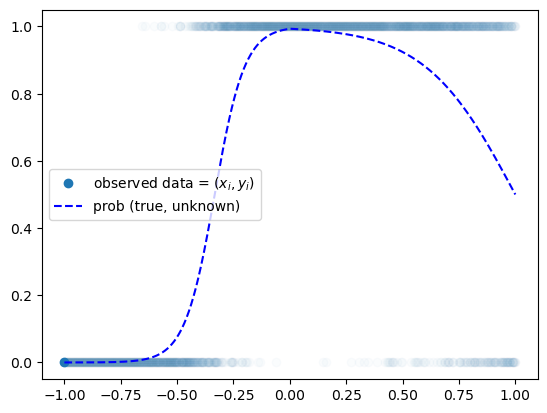

In [30]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.legend()

## B. Step 1~4

`-` Step1에 대한 생각: 네트워크를 어떻게 만들까? = 아키텍처를 어떻게
만들까? = 모델링

$$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,2)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,2)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$$

`-` Step2,3,4 는 너무 뻔해서..

In [31]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(1,2),
    torch.nn.ReLU(),
    torch.nn.Linear(2,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
for epoc in range(3000):
    ## 
    yhat = net(x)
    ## 
    loss = loss_fn(yhat,y)
    ## 
    loss.backward()
    ## 
    optimizr.step()
    optimizr.zero_grad()

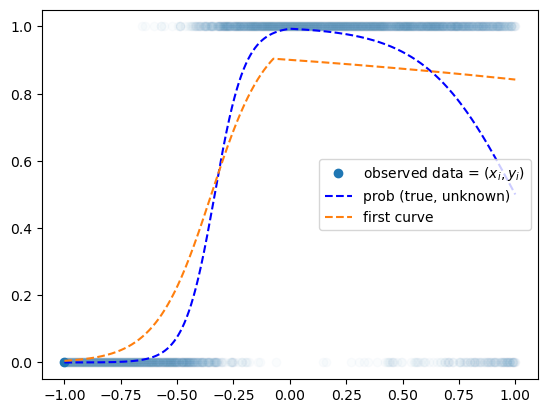

In [32]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.plot(x,net(x).data,'--',label="first curve")
plt.legend()

In [33]:
for epoc in range(3000):
    ## 
    yhat = net(x)
    ## 
    loss = loss_fn(yhat,y)
    ## 
    loss.backward()
    ## 
    optimizr.step()
    optimizr.zero_grad()

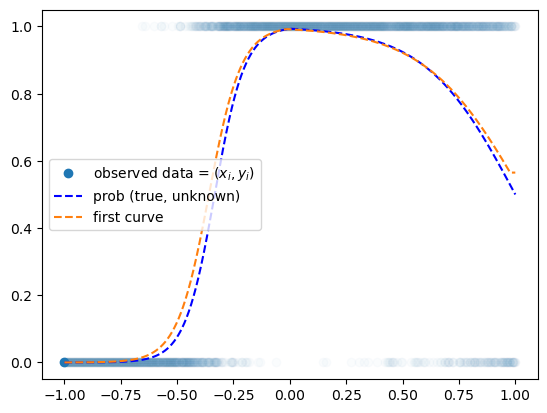

In [34]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.plot(x,net(x).data,'--',label="first curve")
plt.legend()